<a href="https://colab.research.google.com/github/philhuang74/philhuang74.github.io/blob/master/BlogPost3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Today, we are going to create a neural network for detecting fake news. 
First we will import the needed packages for this task.

In [243]:
import pandas as pd
import numpy as np
import tensorflow as tf
import re
import string
from matplotlib import pyplot as plt

# For removing stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# For building model
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow import keras

from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.layers.experimental.preprocessing import StringLookup

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# For our embedding vizualization
import plotly.express as px 
import plotly.io as pio
pio.templates.default = "plotly_white"

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [244]:
#pip install tensorflow==2.4

Next we will import the data.

In [245]:
train_url = "https://github.com/PhilChodrow/PIC16b/blob/master/datasets/fake_news_train.csv?raw=true"

In [246]:
df = pd.read_csv(train_url)

Now we will create a function that will create a tensorflow dataset where we remove stopwords such as "the", "and", "but" from the text and title column and put them as the input (first part of tuple), and the output as whether the news was fake.

In [247]:
def make_dataset(df):
  

  stop = stopwords.words("english")

  df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in (stop)]))
  df['title'] = df['title'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in (stop)]))

  #test['tweet'].apply(lambda x: [item for item in x if item not in stop])
  # Creating tensorflow dataset
  data = tf.data.Dataset.from_tensor_slices(
      (
        {
          "title" :  df[["title"]],
          "text" : df[["text"]]
       },

        {
          "fake" : df[["fake"]]
        }
      )
  )

  return data

In [284]:
stop = stopwords.words("english")
stop[0:5]

['i', 'me', 'my', 'myself', 'we']

In [248]:
df

,Unnamed: 0,title,text,fake
0,17366,Merkel: Strong result for Austria's FPO 'big c...,German Chancellor Angela Merkel said on Monday...,0
1,5634,Trump says Pence will lead voter fraud panel,"WEST PALM BEACH, Fla.President Donald Trump sa...",0
2,17487,JUST IN: SUSPECTED LEAKER and “Close Confidant...,"On December 5, 2017, Circa s Sara Carter warne...",1
3,12217,Thyssenkrupp has offered help to Argentina ove...,"Germany s Thyssenkrupp, has offered assistance...",0
4,5535,Trump say appeals court decision on travel ban...,President Donald Trump on Thursday called the ...,0
...,...,...,...,...
22444,10709,ALARMING: NSA Refuses to Release Clinton-Lynch...,If Clinton and Lynch just talked about grandki...,1
22445,8731,Can Pence's vow not to sling mud survive a Tru...,"() - In 1990, during a close and bitter congre...",0
22446,4733,Watch Trump Campaign Try To Spin Their Way Ou...,A new ad by the Hillary Clinton SuperPac Prior...,1
22447,3993,"Trump celebrates first 100 days as president, ...","HARRISBURG, Pa.U.S. President Donald Trump hit...",0


We will pass our dataframe into our make_dataset function and print the first five input and outputs in our dataset.

In [249]:
data = make_dataset(df)

for input, output in data.take(5):
    print(input)
    print(output)
    print("")

{'title': <tf.Tensor: shape=(1,), dtype=string, numpy=
array([b"Merkel: Strong result Austria's FPO 'big challenge' parties"],
      dtype=object)>, 'text': <tf.Tensor: shape=(1,), dtype=string, numpy=
array([b'German Chancellor Angela Merkel said Monday strong showing Austria anti-immigrant Freedom Party (FPO) Sunday election big challenge parties. Speaking news conference Berlin, Merkel added hoping close cooperation Austria conservative election winner Sebastian Kurz European level.'],
      dtype=object)>}
{'fake': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>}

{'title': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Trump says Pence lead voter fraud panel'], dtype=object)>, 'text': <tf.Tensor: shape=(1,), dtype=string, numpy=
array([b'WEST PALM BEACH, Fla.President Donald Trump said remarks broadcast Sunday would put Vice President Mike Pence charge commission probe believes voter fraud last November\'s election. overwhelming consensus among state officials, electi

Next, we will shuffle our data and take 80 percent of the data as training data and the remaining 20 percent to be validation data. We will batch our data by 100 items.

In [250]:
data = data.shuffle(buffer_size = len(data))

train_size = int(0.8*len(data))
val_size   = int(0.2*len(data))

train = data.take(train_size).batch(100)
val   = data.skip(train_size).take(val_size).batch(100)

len(train), len(val)

(180, 45)

Next we will standardize our data so that everything is lower case and remove the punctuations

In [251]:
def standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    no_punctuation = tf.strings.regex_replace(lowercase,
                                  '[%s]' % re.escape(string.punctuation),'')
    return no_punctuation

We will then vectorize our data, since computers can't understand words but can understand numbers. 

In [252]:
size_vocabulary = 2000

vectorize_layer = TextVectorization(
    standardize = standardization,
    max_tokens = size_vocabulary,
    output_mode = "int",
    output_sequence_length = 500)

vectorize_layer.adapt(train.map(lambda x, y: x["title"]))
vectorize_layer.adapt(train.map(lambda x, y: x["text"]))

We will now start to prepare building our model. We will first specify the input of our model, which is title.

In [253]:
title_input = keras.Input(
    shape = (1,),
    name = "title",
    dtype = "string"
)

We will add an embedding layer. It is best to define a layer here so that later we can access the word embeddings of the words in both title and text.

In [254]:
embedding_layer = layers.Embedding(size_vocabulary, 10, name = "embedding")

We will use keras Functional API to build our model. We will first look at how well the title features predict whether the news is fake.

In [255]:
title_features = vectorize_layer(title_input)
title_features = embedding_layer(title_features)
title_features = layers.Dropout(0.2)(title_features)
title_features = layers.GlobalAveragePooling1D()(title_features)
title_features = layers.Dropout(0.2)(title_features)
title_features = layers.Dense(32, activation='relu')(title_features)
title_output = layers.Dense(2, name = "fake")(title_features)

Since there are two possible outcomes, whether the news if fake or not, our output layer is a dense layer with 2 as a parameter.

We will then check our model by calling the summary method.


In [256]:
model_title = keras.Model(
    inputs = title_input,
    outputs = title_output
)

model_title.summary()

Model: "model_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
title (InputLayer)           [(None, 1)]               0         
_________________________________________________________________
text_vectorization_7 (TextVe (None, 500)               0         
_________________________________________________________________
embedding (Embedding)        (None, 500, 10)           20000     
_________________________________________________________________
dropout_30 (Dropout)         (None, 500, 10)           0         
_________________________________________________________________
global_average_pooling1d_15  (None, 10)                0         
_________________________________________________________________
dropout_31 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 32)                352

Model summary can often be hard to understand, we can also use diagrams to see how our model works

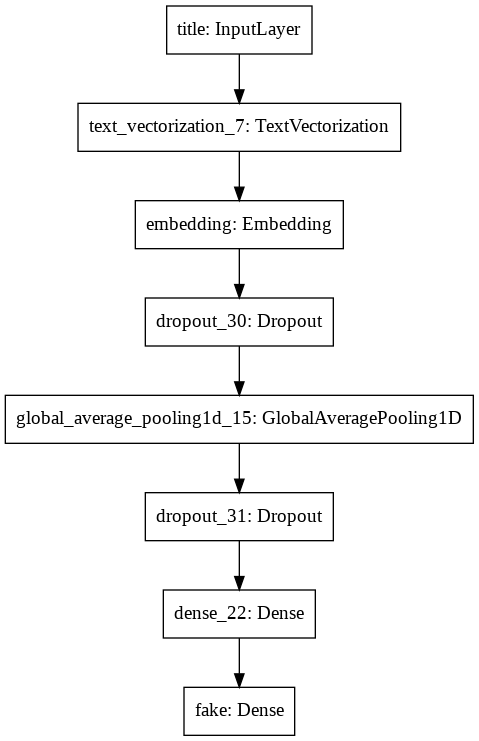

In [257]:
keras.utils.plot_model(model_title)

We will now compile our model with the adam optimizer.

In [258]:
model_title.compile(optimizer = "adam",
              loss = losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']
)

We are going to train our training data for 50 epochs.

In [259]:
history_title = model_title.fit(train, 
                    validation_data=val,
                    epochs = 50, 
                    verbose = True)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/functional.py:595: UserWarning:

Input dict contained keys ['text'] which did not match any model input. They will be ignored by the model.



180/180 [==============================] - 2s 10ms/step - loss: 0.6923 - accuracy: 0.5201 - val_loss: 0.6909 - val_accuracy: 0.5215
Epoch 2/50
180/180 [==============================] - 2s 9ms/step - loss: 0.6894 - accuracy: 0.5370 - val_loss: 0.6749 - val_accuracy: 0.5284
Epoch 3/50
180/180 [==============================] - 2s 8ms/step - loss: 0.6602 - accuracy: 0.6569 - val_loss: 0.5617 - val_accuracy: 0.8452
Epoch 4/50
180/180 [==============================] - 2s 8ms/step - loss: 0.5255 - accuracy: 0.8171 - val_loss: 0.4002 - val_accuracy: 0.8496
Epoch 5/50
180/180 [==============================] - 2s 8ms/step - loss: 0.3913 - accuracy: 0.8469 - val_loss: 0.3372 - val_accuracy: 0.8641
Epoch 6/50
180/180 [==============================] - 2s 8ms/step - loss: 0.3346 - accuracy: 0.8592 - val_loss: 0.3021 - val_accuracy: 0.8679
Epoch 7/50
180/180 [==============================] - 2s 8ms/step - loss: 0.3106 - accuracy: 0.8670 - val_loss: 0.2910 - val_accuracy: 0.8726
Epoch 8/50
180/1

Now we would like to plot how accurate our model is with the training data.


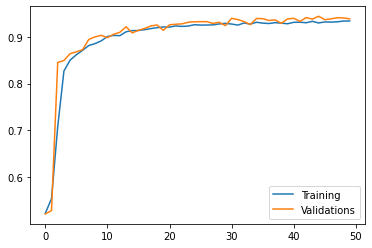

In [260]:

plt.plot(history_title.history["accuracy"], label = "Training")
plt.plot(history_title.history["val_accuracy"], label = "Validations")
plt.legend()

Looks like our model achieved about 93 percent accuracy in both the training and validation data. 

Now we are going to experiment with just the text features and build a model see how accurate it is in predicting fake news.

In [261]:
text_input = keras.Input(
    shape = (1,),
    name = "text",
    dtype = "string"
)

In [264]:
text_features = vectorize_layer(text_input)
text_features = embedding_layer(text_features)
text_features = layers.Dropout(0.2)(text_features)
text_features = layers.GlobalAveragePooling1D()(text_features)
text_features = layers.Dropout(0.2)(text_features)
text_features = layers.Dense(32, activation='relu')(text_features)
text_output = layers.Dense(2, name = "fake")(text_features)

In [265]:
model_text = keras.Model(
    inputs = text_input,
    outputs = text_output
)

model_text.summary()

Model: "model_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text (InputLayer)            [(None, 1)]               0         
_________________________________________________________________
text_vectorization_7 (TextVe (None, 500)               0         
_________________________________________________________________
embedding (Embedding)        (None, 500, 10)           20000     
_________________________________________________________________
dropout_34 (Dropout)         (None, 500, 10)           0         
_________________________________________________________________
global_average_pooling1d_17  (None, 10)                0         
_________________________________________________________________
dropout_35 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 32)                352

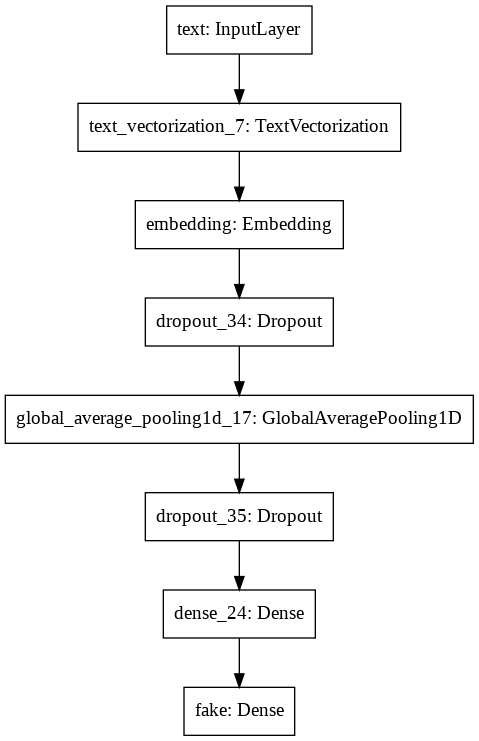

In [266]:
keras.utils.plot_model(model_text)

In [267]:
model_text.compile(optimizer = "adam",
              loss = losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']
)

In [268]:
history_text = model_text.fit(train, 
                    validation_data=val,
                    epochs = 50, 
                    verbose = True)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/functional.py:595: UserWarning:

Input dict contained keys ['title'] which did not match any model input. They will be ignored by the model.



180/180 [==============================] - 4s 18ms/step - loss: 0.6555 - accuracy: 0.5754 - val_loss: 0.4393 - val_accuracy: 0.8425
Epoch 2/50
180/180 [==============================] - 3s 16ms/step - loss: 0.3793 - accuracy: 0.8632 - val_loss: 0.2324 - val_accuracy: 0.9256
Epoch 3/50
180/180 [==============================] - 3s 16ms/step - loss: 0.2358 - accuracy: 0.9152 - val_loss: 0.1790 - val_accuracy: 0.9356
Epoch 4/50
180/180 [==============================] - 3s 16ms/step - loss: 0.1927 - accuracy: 0.9377 - val_loss: 0.1662 - val_accuracy: 0.9463
Epoch 5/50
180/180 [==============================] - 3s 16ms/step - loss: 0.1589 - accuracy: 0.9458 - val_loss: 0.1482 - val_accuracy: 0.9552
Epoch 6/50
180/180 [==============================] - 3s 16ms/step - loss: 0.1464 - accuracy: 0.9534 - val_loss: 0.1266 - val_accuracy: 0.9666
Epoch 7/50
180/180 [==============================] - 3s 16ms/step - loss: 0.1328 - accuracy: 0.9599 - val_loss: 0.1064 - val_accuracy: 0.9728
Epoch 8/50

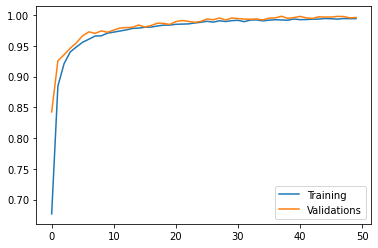

In [269]:
plt.plot(history_text.history["accuracy"], label = "Training")
plt.plot(history_text.history["val_accuracy"], label = "Validations")
plt.legend()

It looks like our text model achieve 99 percent accuracy on both the training and validation data. This makes sense as text should give more information on whether the news is fake or not than title.

One cool thing about keras functional API is we can have more than one kind of feature to predict whether the news is fake. We will first merge our title and text features by column so they are stacked side by side.

In [270]:
main_title_text = layers.concatenate([title_features, text_features], axis = 1)

We will then just create two dense layers for our model. The activation function will be "relu".

In [271]:
main_title_text = layers.Dense(32, activation='relu')(main_title_text)
title_text_output = layers.Dense(2, name = "fake")(main_title_text)

In [272]:
model_title_text = keras.Model(
    inputs = [title_input, text_input],
    outputs = title_text_output
)

model_title_text.summary()

Model: "model_23"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
title (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
text (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
text_vectorization_7 (TextVecto (None, 500)          0           title[0][0]                      
                                                                 text[0][0]                       
__________________________________________________________________________________________________
embedding (Embedding)           (None, 500, 10)      20000       text_vectorization_7[0][0]

In [273]:
model_title_text.compile(optimizer = "adam",
              loss = losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']
)

In [274]:
history_title_text = model_title_text.fit(train, 
                    validation_data=val,
                    epochs = 50, 
                    verbose = True)

Epoch 1/50
180/180 [==============================] - 5s 20ms/step - loss: 0.3338 - accuracy: 0.8985 - val_loss: 0.0377 - val_accuracy: 0.9960
Epoch 2/50
180/180 [==============================] - 3s 19ms/step - loss: 0.0374 - accuracy: 0.9908 - val_loss: 0.0196 - val_accuracy: 0.9964
Epoch 3/50
180/180 [==============================] - 3s 19ms/step - loss: 0.0249 - accuracy: 0.9941 - val_loss: 0.0162 - val_accuracy: 0.9960
Epoch 4/50
180/180 [==============================] - 3s 19ms/step - loss: 0.0204 - accuracy: 0.9948 - val_loss: 0.0132 - val_accuracy: 0.9975
Epoch 5/50
180/180 [==============================] - 3s 19ms/step - loss: 0.0188 - accuracy: 0.9952 - val_loss: 0.0124 - val_accuracy: 0.9978
Epoch 6/50
180/180 [==============================] - 3s 19ms/step - loss: 0.0191 - accuracy: 0.9943 - val_loss: 0.0119 - val_accuracy: 0.9967
Epoch 7/50
180/180 [==============================] - 3s 19ms/step - loss: 0.0155 - accuracy: 0.9965 - val_loss: 0.0102 - val_accuracy: 0.9978

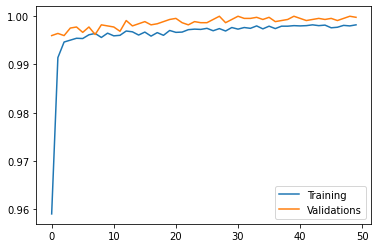

In [275]:
plt.plot(history_title_text.history["accuracy"], label = "Training")
plt.plot(history_title_text.history["val_accuracy"], label = "Validations")
plt.legend()

It seems our model using both title and text reached a near 100 percent accuracy. It improved just a little more than the text model by itself. This is the power of the functional API where we can have more than one type of input into our neural network. It seems like if we want the best model for detecting fake news, taking both the title and text is the best way to go.

Now lets test this model on our test data.

In [276]:
test_url = "https://github.com/PhilChodrow/PIC16b/blob/master/datasets/fake_news_test.csv?raw=true"
test_df = pd.read_csv(test_url)
test_df

,Unnamed: 0,title,text,fake
0,420,"CNN And MSNBC Destroy Trump, Black Out His Fa...",Donald Trump practically does something to cri...,1
1,14902,Exclusive: Kremlin tells companies to deliver ...,The Kremlin wants good news. The Russian lead...,0
2,322,Golden State Warriors Coach Just WRECKED Trum...,"On Saturday, the man we re forced to call Pre...",1
3,16108,"Putin opens monument to Stalin's victims, diss...",President Vladimir Putin inaugurated a monumen...,0
4,10304,BREAKING: DNC HACKER FIRED For Bank Fraud…Blam...,Apparently breaking the law and scamming the g...,1
...,...,...,...,...
22444,20058,U.S. will stand be steadfast ally to Britain a...,The United States will stand by Britain as it ...,0
22445,21104,Trump rebukes South Korea after North Korean b...,U.S. President Donald Trump admonished South K...,0
22446,2842,New rule requires U.S. banks to allow consumer...,U.S. banks and credit card companies could be ...,0
22447,22298,US Middle Class Still Suffering from Rockefell...,Dick Eastman The Truth HoundWhen Henry Kissin...,1


In [277]:
test_data = make_dataset(test_df)

for input, output in test_data.take(5):
    print(input)
    print(output)
    print("")

{'title': <tf.Tensor: shape=(1,), dtype=string, numpy=
array([b'CNN MSNBC Destroy Trump, Black Fact-Free Tax Reform Speech (TWEET)'],
      dtype=object)>, 'text': <tf.Tensor: shape=(1,), dtype=string, numpy=
array([b'Donald Trump practically something criticize media fake news almost daily basis, two major news networks turned tables put blast major way.The White House currently arms recent decision MSNBC, decided air Trump insanely dishonest North Dakota speech earlier today. Trump supposed address tax reform speech, major problem saying word true. response fact-free speech, MSNBC decided irresponsible air speech decided spare Americans misinformation nonsense.Once Trump administration found move press, White House practically threw hissy fit. Special Assistant President Assistant White House Communications Director Steven Chueng tweeted:Instead insulting viewers Trump lies, MSNBC Nicole Wallace reported important, truthful topics DACA Russia. Jake Tapper focused Hurricane Irma, Russ

In [278]:
model_title_text.evaluate(test_data)

22449/22449 [==============================] - 81s 4ms/step - loss: 0.1133 - accuracy: 0.9827


[0.11332923173904419, 0.9827163815498352]

Looks like our model had an accuracy of 98 percent in predicting fake news on the test data. Our model seems to have caught onto some words weighted more towards fake news. 

Since we gave a name to our embedding layer above, we can now get the weights of the embedding layer that the model has learned.

In [279]:
weights = model_title_text.get_layer('embedding').get_weights()[0] # get the weights from the emebdding layer
vocab = vectorize_layer.get_vocabulary()  

We will use PCA to reduce our embedding layer which has dimension 10 to dimension 2 so that we can visualize what our model has learned.

In [280]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
weights = pca.fit_transform(weights)

embedding_df = pd.DataFrame({
    'word' : vocab, 
    'x0'   : weights[:,0],
    'x1'   : weights[:,1]
})

embedding_df

,word,x0,x1
0,,-0.111371,0.068357
1,[UNK],0.006190,0.125544
2,said,-3.187494,-1.664343
3,trump,0.615793,1.248399
4,us,-2.254699,0.566764
...,...,...,...
1995,add,0.917946,-0.160608
1996,abroad,-2.022529,-0.962712
1997,was,-0.488677,0.320916
1998,threatening,4.781887,-0.049361


Now we can plot our word embedding. 

In [281]:
import plotly.express as px 
fig = px.scatter(embedding_df, 
                 x = "x0", 
                 y = "x1", 
                 size = list(np.ones(len(embedding_df))),
                 size_max = 2,
                 hover_name = "word")

fig.show()

It seems like our model has picked up some words on the right that seem to be more conservative such as Trump, election , mitch, 2008, texas, carolina, flynn, fox, abortion, hannity, mueller, ted while words on the left are more neutral words such as democracy, healthcare, mission, capital, that don't seem to have political affiliation with the exception of Vladimir in the middle bottom left. I am not sure how our model has been able to detect fake news, but our model seems to have learned words that correspond to a political affiliation while the other side (left) is less politically affiliated.